In [1]:
# Run for GPU/CUDA ML, comment out if you dont have it configured.
import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [2]:
import numpy as np
from numpy import mean, std, dstack
import keras.backend as kb
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, ConvLSTM2D
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

## 4 gestures, windowsize = 100, overlap = 50
window_100_50 = ["ready_data/window-100-50/x_train.txt", "ready_data/window-100-50/y_train.txt",
                 "ready_data/window-100-50/x_test.txt", "ready_data/window-100-50/y_test.txt"]

num_gestures = 4
window = 100
overlap = 50
data_columns = 6
model_name = 'lstm_model_' + str(window) + '_' + str(overlap)


if num_gestures == 4:
    if overlap == 50 and window == 100:
        directory = window_100_50


## Load data previously saved as numpy text and reshape it to orginal form
loaded_arr = np.loadtxt(directory[0])
x_train = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // data_columns, data_columns)

loaded_arr1 = np.loadtxt(directory[1])
y_train = loaded_arr1

loaded_arr2 = np.loadtxt(directory[2])
x_test = loaded_arr2.reshape(loaded_arr2.shape[0], loaded_arr2.shape[1] // data_columns, data_columns)

loaded_arr3 = np.loadtxt(directory[3])
y_test = loaded_arr3

print('##Before reshaping')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

y_train = to_categorical(y_train, num_classes = num_gestures)
y_test = to_categorical(y_test, num_classes = num_gestures)

print('##After reshaping')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

##Before reshaping
(15272, 100, 6)
(15272,)
(6548, 100, 6)
(6548,)
##After reshaping
(15272, 100, 6)
(15272, 4)
(6548, 100, 6)
(6548, 4)


In [3]:
print(y_test[0])

[1. 0. 0. 0.]


In [4]:
def visualise(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



In [5]:
def evaluate_lstm(x_train, y_train, x_test, y_test, dropout):
    print("start evaluation!")
    LR = 0.0001
    verbose, epochs, batch_size = 1, 20, 64
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    ##LSTM model structure
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps, n_features), dropout=dropout))
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    opt = Adam(lr=LR)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

    model.summary()
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                        validation_data=(x_test, y_test),  shuffle=True)
    ##plot
    visualise(history)

    # save model
    if not os.path.exists('lstm_models'):
        os.makedirs('lstm_models')
    model_name = 'lstm_models/lstm_model_' + str(window) + '_' + str(overlap)
    model.save(model_name)
    # evaluate model
    _, accuracy, cat_acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=verbose)
    return accuracy


# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

start evaluation!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 53,304
Trainable params: 53,304
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
239/239 [==============================] - 3s 13ms/step - loss: 1.2343 - accuracy: 0.4572 - categorical_accuracy: 0.4572 - val_loss: 0.9105 - val_accuracy: 0.6668 - val_categorical_accuracy: 0.6668
Epoch 2/20
239/239 [===

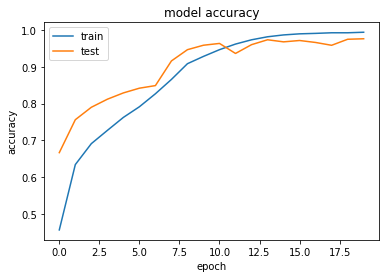

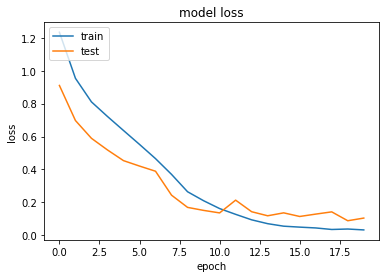

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_models/lstm_model_100_50\assets
103/103 [==============================] - 1s 5ms/step - loss: 0.1038 - accuracy: 0.9757 - categorical_accuracy: 0.9757
>#1: 97.572
[97.57177829742432]
Accuracy: 97.572% (+/-0.000)


In [6]:
# run an experiment
def run_experiment(repeats=1):
    # repeat experiment
    dropout = 0.2
    # dropout = [0.0, 0.2, 0.3, 0.4, 0.5]
    scores = list()
    for r in range(repeats):
        score = evaluate_lstm(x_train, y_train, x_test, y_test, dropout)
        score = score * 100.0
        print('>#%d: %.3f' % (r + 1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)


# run the experiment
run_experiment()


## Testing the model

In [7]:
from keras.models import load_model
## Location of the model
model_name = 'lstm_model_100_50'

model = load_model(model_name)

In [8]:
y_pred = model.predict(x_test)

In [9]:
y_pred_label = np.argmax(y_pred, axis=1)
y_label = np.argmax(y_test, axis=1)
print(y_pred_label)
print(y_label)

[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


In [10]:
if num_gestures == 4:
    class_names = ["Buddha clap", "Knob", "Pushback", "Swipe"]
elif num_gestures == 5:
    class_names = ["Buddha clap", "Crank", "Knob", "Pushback", "Swipe"]
elif num_gestures == 7:
    class_names = ["Buddha clap", "Crank left", "Crank right", "Knob left", "Knob right", "Pushback", "Swipe"]

name = np.array(class_names)
print(name)
print(type(name))

['Buddha clap' 'Knob' 'Pushback' 'Swipe']
<class 'numpy.ndarray'>


In [11]:
output = []

for i in range(len(y_label)):
    if y_label[i] != y_pred_label[i]:
        actual = class_names[y_label[i]]
        pred = class_names[y_pred_label[i]]
        output.append([actual, pred])
        print("Actual: %s, Prediction: %s" % (actual, pred))

Actual: Buddha clap, Prediction: Knob
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Buddha clap, Prediction: Swipe
Actual: Knob, Prediction: Pushback
Actual: Knob, Prediction: Pushback
Actual: Knob, Prediction: Pushback
Actual: Knob, Prediction: Pushback
Actual: Knob, Prediction: Pushback
Actual: Knob, Prediction: Pushback
Actual: Kno

In [12]:
import csv
from datetime import datetime

fields = ['Actual', 'Predicted']
now = datetime.now()
file = 'output_' + now.strftime("%d-%m-%Y_%H-%M-%S") + '.csv'
with open(file, 'w', newline='') as filename:
    write = csv.writer(filename)
    write.writerow(fields)
    write.writerows(output)
